In [18]:
from matplotlib import pyplot as plt
import pandas as pd
from utils import save_fig_for_raport, dataframe_to_latex_tabular 
from pandas.plotting import autocorrelation_plot
import pandas.plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from kats.consts import TimeSeriesData
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.detectors.seasonality import FFTDetector
from kats.detectors.outlier import OutlierDetector

In [2]:
raw_data = pd.read_csv('../datasets/raw/market_insights_overview_all_2022_04_26_filtered.csv', parse_dates=["date"])

# Filter away early 2018 data as it seems to contain errors
raw_data =raw_data .loc[raw_data ['date'] > '2018-12-01']

In [3]:
categories = pd.read_csv("../datasets/raw/solr_categories_all_2022_02_14.csv")
# Join market_insight table with category names
category_names = categories[[ "internal_doc_id", "title"]]
category_id_to_names_map = dict(map(lambda x: (x["internal_doc_id"], x["title"]), category_names.to_dict("records")))
category_name_to_id_map = dict(map(lambda x: (x["title"], x["internal_doc_id"]), category_names.to_dict("records")))

In [4]:

data_grouped = raw_data.groupby(['cat_id', "date"], as_index=False).sum()
data_grouped["date"] = pd.to_datetime(data_grouped["date"])
data_grouped["interest"] = data_grouped["hits"] + data_grouped["clicks"]

# Join with category names
data_grouped = pd.merge(data_grouped , category_names, how="left", left_on=["cat_id"], right_on=["internal_doc_id"])
data_grouped.rename(columns={"title": "cat_name"}, inplace=True)
data_grouped.drop(columns=["internal_doc_id"], inplace=True, axis=1)

data_chosen_categories = data_grouped[["interest", "date", "cat_id", "cat_name"]]
data = data_chosen_categories
data.head()

,interest,date,cat_id,cat_name
0,2751,2018-12-02,2,Bærbar PC
1,3307,2018-12-03,2,Bærbar PC
2,3461,2018-12-04,2,Bærbar PC
3,3158,2018-12-05,2,Bærbar PC
4,3245,2018-12-06,2,Bærbar PC


In [5]:
# Fill in all missing days
#data_grouped_filled_dates = data_chosen_categories.groupby(pd.Grouper(key="date", freq='D')).sum()

#data = data_grouped_filled_dates
#data.head()

In [5]:
# Pivot table by cat_id
data_by_cat_id = data.pivot(index=["date"], columns=["cat_id", "cat_name"])["interest"]

In [6]:
corr_categories = [2, 6, 9, 10, 11, 13, 20]

seasonal_categories_cat_name =["Vinterjakke",
"Vintersko",
"Langrennski",
"Skisko",
"Varmeovn",
"Snøfreser",
"Snøskuffe",]

seasonal_categories = list(map(lambda x: category_name_to_id_map[x], seasonal_categories_cat_name))
seasonal_categories

[12322, 11428, 11850, 11852, 273, 11036, 11213]

AttributeError: 'Line2D' object has no property 'title'

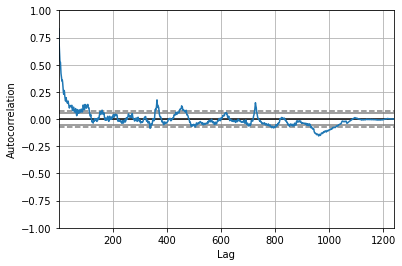

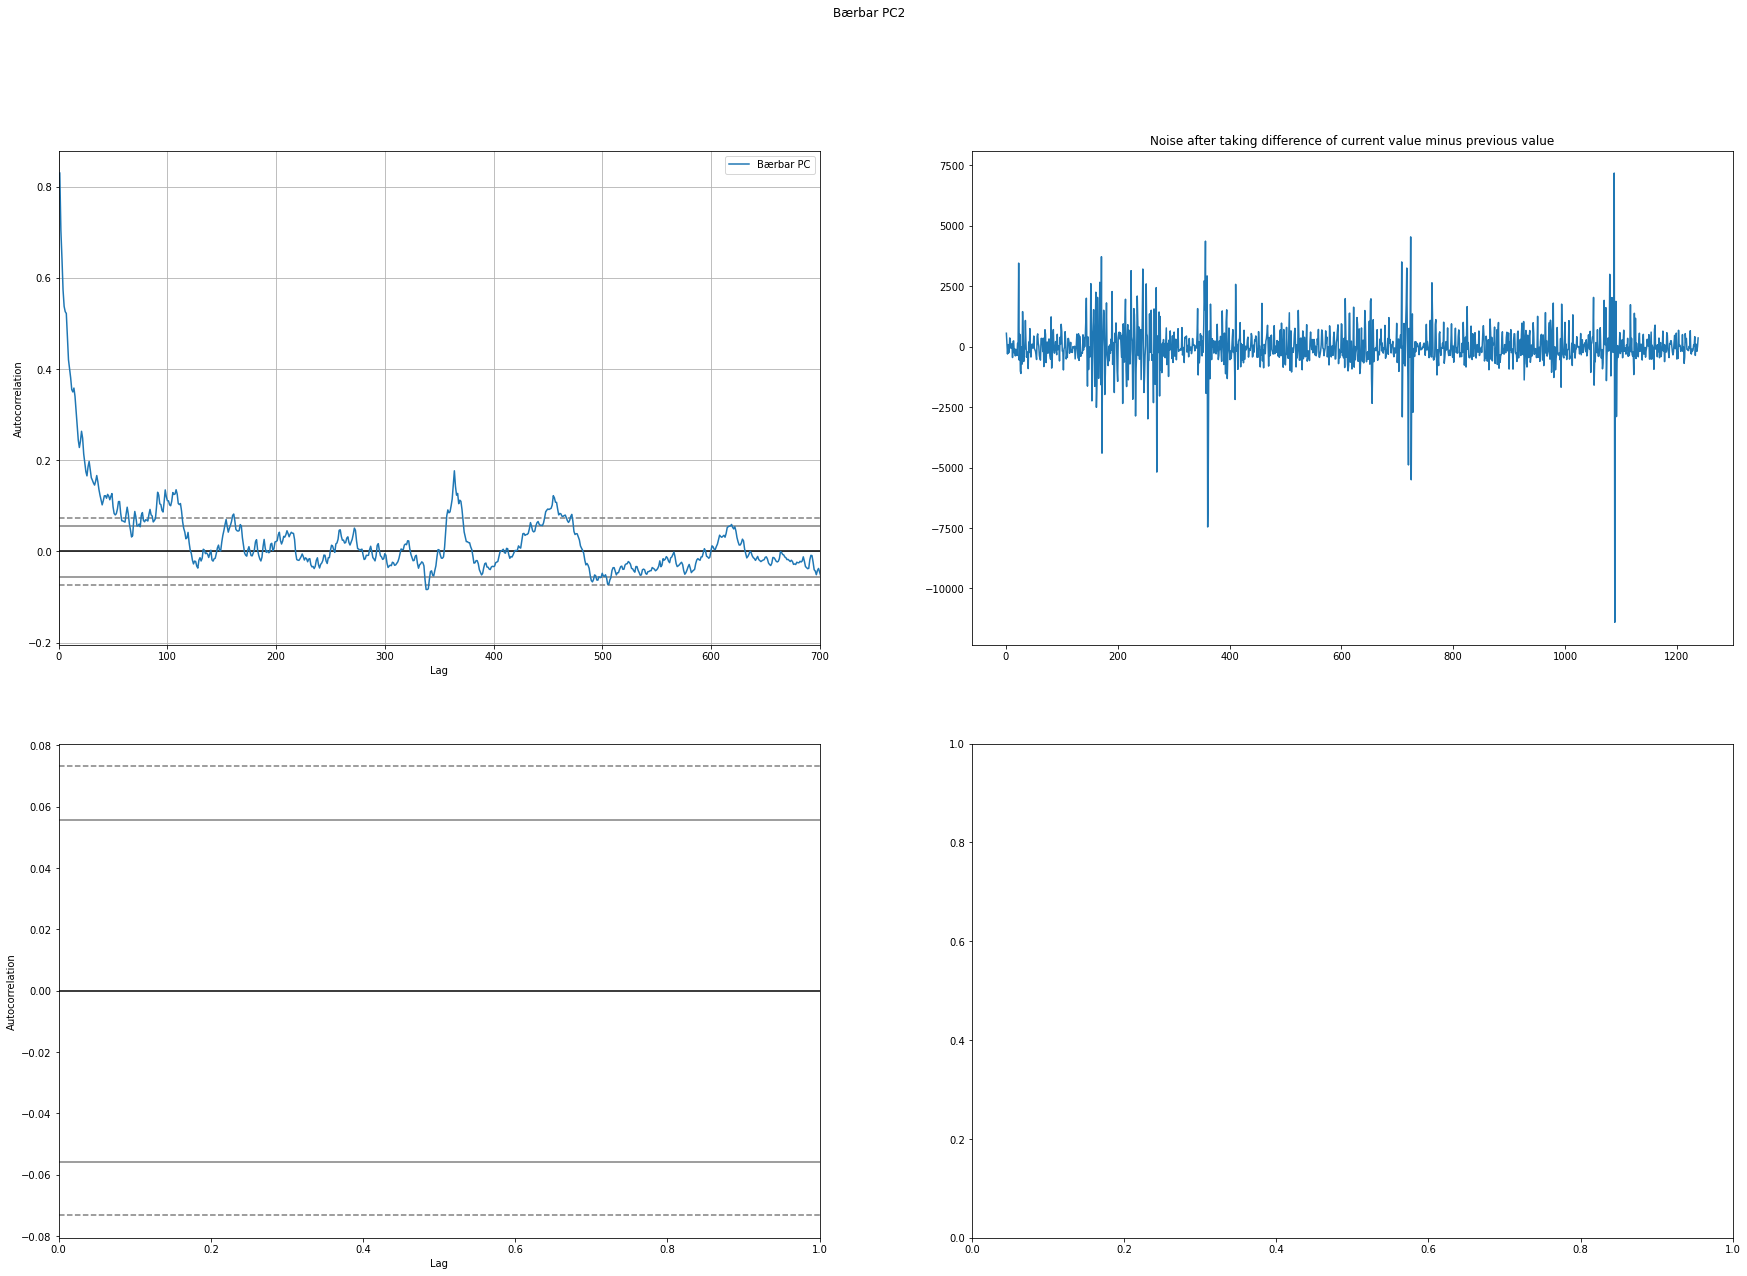

In [33]:
import numpy as np
pandas.plotting.autocorrelation_plot(data[data["cat_id"] == 2]["interest"])
for cat in corr_categories + seasonal_categories:
cat_name = category_id_to_names_map[cat] if cat in category_id_to_names_map else cat
filtered = data[data["cat_id"] == cat]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))
fig.suptitle(cat_name + str(cat))
ax = pandas.plotting.autocorrelation_plot(filtered["interest"], label=cat_name, ax=axes[0,0]).set_xlim([0, 700])
# Plot random walk. 
walk_diff = filtered["interest"].diff()
diff_series = np.array(walk_diff)
diff = []
for i in range(1, len(diff_series)):
  value = diff_series[i] - diff_series[i-1]
  diff.append(value)
walk_diff.plot(title="Noise after taking difference of current value minus previous value", label="Noise", ax=axes[0, 1])
pandas.plotting.autocorrelation_plot(diff[1:], label="Noise", ax=axes[1, 0] ).set_xlim([0, 400])


nettverkskabler = filtered.rename(columns={"date": "time"})
ts = TimeSeriesData(nettverkskabler[["time", "interest"]])
decomposer = TimeSeriesDecomposition(ts, decomposition="additive", robust=True, seasonal=365)
results = decomposer.decomposer()
# fig = decomposer.plot()
residuals = results["rem"].to_dataframe()["resid"]
pandas.plotting.autocorrelation_plot(residuals, label="Noise", ax=axes[1, 1]).set_xlim([0, 400])

## Dicky-Fuller test
"
If the found slope (β) is equal to 0, the series is a random walk. If the slope is significantly different from 0, we reject the null hypothesis that the series follows a random walk.
"

We look at the p-value, which is ~0.26. Since 0.05 is the significance threshold, we fail to reject the null hypothesis that drifty_walk is a random walk, i.e., it is a random walk.

1. If ADF statistics < critical calues => Reject the null hypothesis (it is stationary)
2. if ADF statistics > critical values => failed to reject the null hypothosis

In [9]:
def df_test(df):
  filtered = df
  dicky_fuller_test = adfuller(filtered, autolag='AIC')
  print(f"catregory: {cat}, {category_id_to_names_map[cat] if cat in category_id_to_names_map else cat}")
  print(
        f"p-value: {dicky_fuller_test[1]}\n",
        f"ADF Statistic: {dicky_fuller_test[0]}\n",
  )
  for key, value in dicky_fuller_test[4].items():
    print(f"Critical value for {key} at {dicky_fuller_test[1]}: {value}")
  print("\n")
  return {
    "Category_name": category_id_to_names_map[cat] if cat in category_id_to_names_map else cat, 
    "p-value": dicky_fuller_test[1],
     "ADF Statistic": dicky_fuller_test[0],
     "Critical value for '1%':": dicky_fuller_test[4]['1%'],
     "Critical value for '5%':": dicky_fuller_test[4]['5%'],
     "Critical value for '10%':": dicky_fuller_test[4]['10%'],}

In [10]:
for cat in seasonal_categories + corr_categories:
  filtered = data[data["cat_id"] == cat]["interest"]
  df_test(filtered)

catregory: 12322, Vinterjakke
p-value: 0.0026238168366645143
 ADF Statistic: -3.8290368836317783

Critical value for 1% at 0.0026238168366645143: -3.4381401994155976
Critical value for 5% at 0.0026238168366645143: -2.864978699501589
Critical value for 10% at 0.0026238168366645143: -2.568601040504172


catregory: 11428, Vintersko
p-value: 0.014397865306719484
 ADF Statistic: -3.3109081542977603

Critical value for 1% at 0.014397865306719484: -3.4360590437486405
Critical value for 5% at 0.014397865306719484: -2.864060922068716
Critical value for 10% at 0.014397865306719484: -2.5681122011011426


catregory: 11850, Langrennski
p-value: 0.0074469526993673945
 ADF Statistic: -3.521700757119164

Critical value for 1% at 0.0074469526993673945: -3.4360740356772745
Critical value for 5% at 0.0074469526993673945: -2.864067535683479
Critical value for 10% at 0.0074469526993673945: -2.5681157233843748


catregory: 11852, Skisko
p-value: 0.024800384061911578
 ADF Statistic: -3.1243857309917304

Crit

Result:
None of the P-values are below 0.05, which is required to reject the null hypothosis.
None of the time series are stationary.

## Decompose time series
We can decompose each series in into its trend, seasonality and residuals (rest).
Then we can use the dicky-fuller test on the residuals to check if the series is stationary.
If the p-value is < 0.05 it is stationary.
Results: The risiduals are mostly stationary

catregory: 2, Bærbar PC
p-value: 0.00019393585506079455
 ADF Statistic: -4.503326960307715

Critical value for 1% at 0.00019393585506079455: -3.4386757994332813
Critical value for 5% at 0.00019393585506079455: -2.865214793881868
Critical value for 10% at 0.00019393585506079455: -2.5687268080213355


catregory: 6, Digitalkamera
p-value: 0.0002496190010087826
 ADF Statistic: -4.442321544001333

Critical value for 1% at 0.0002496190010087826: -3.4387398917732193
Critical value for 5% at 0.0002496190010087826: -2.8652430432199654
Critical value for 10% at 0.0002496190010087826: -2.5687418568690683


catregory: 9, Harddisk og SSD
p-value: 9.709529762261735e-05
 ADF Statistic: -4.666823713832844

Critical value for 1% at 9.709529762261735e-05: -3.438686413400388
Critical value for 5% at 9.709529762261735e-05: -2.8652194721349424
Critical value for 10% at 9.709529762261735e-05: -2.5687293001910008


catregory: 10, Hovedkort
p-value: 0.018087156373545923
 ADF Statistic: -3.2342245049156353

Cr

/tmp/ipykernel_21906/227163328.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5, 5))


catregory: 11852, Skisko
p-value: 0.09136905082634766
 ADF Statistic: -2.6079314621699767

Critical value for 1% at 0.09136905082634766: -3.4387184182983686
Critical value for 5% at 0.09136905082634766: -2.865233578638179
Critical value for 10% at 0.09136905082634766: -2.5687368149338816


catregory: 273, Varmeovn
p-value: 0.0032296825963301938
 ADF Statistic: -3.7699933654212585

Critical value for 1% at 0.0032296825963301938: -3.4387398917732193
Critical value for 5% at 0.0032296825963301938: -2.8652430432199654
Critical value for 10% at 0.0032296825963301938: -2.5687418568690683


catregory: 11036, Snøfreser
p-value: 0.00066884724488614
 ADF Statistic: -4.196154052035657

Critical value for 1% at 0.00066884724488614: -3.438602251755426
Critical value for 5% at 0.00066884724488614: -2.8651823762743245
Critical value for 10% at 0.00066884724488614: -2.5687095387840673


catregory: 11213, Snøskuffe
p-value: 0.0020794817069807164
 ADF Statistic: -3.8939958069383698

Critical value for 1

<Figure size 360x360 with 0 Axes>

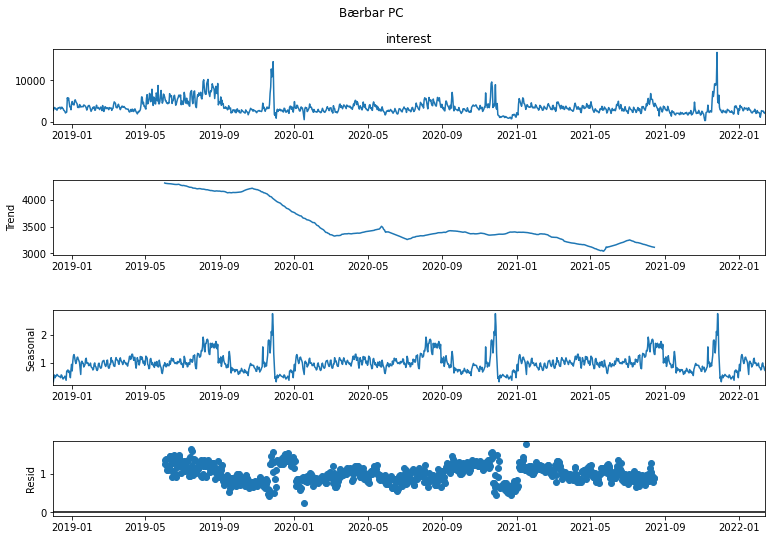

<Figure size 360x360 with 0 Axes>

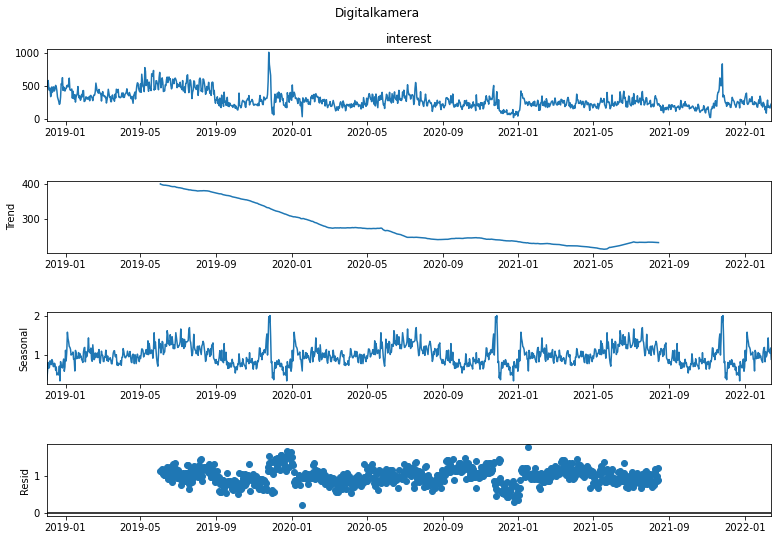

<Figure size 360x360 with 0 Axes>

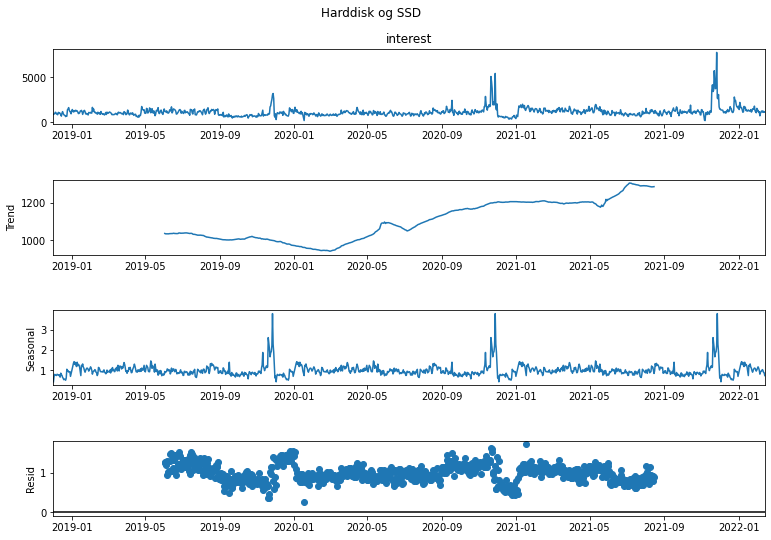

<Figure size 360x360 with 0 Axes>

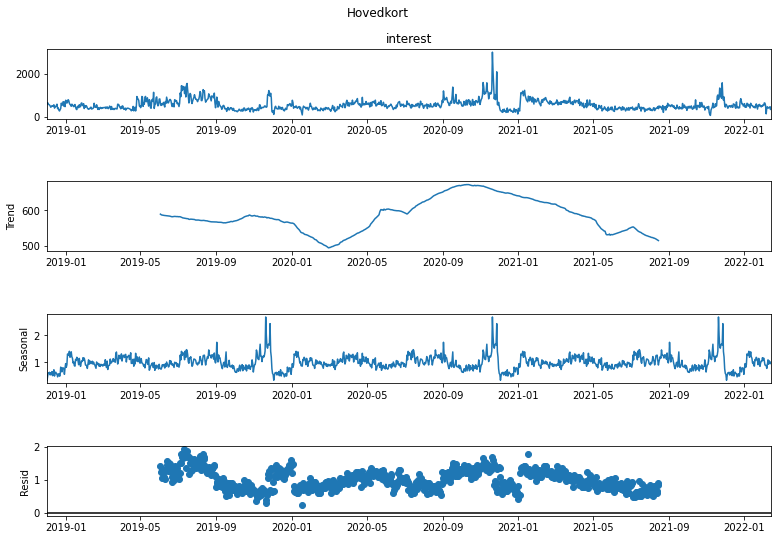

<Figure size 360x360 with 0 Axes>

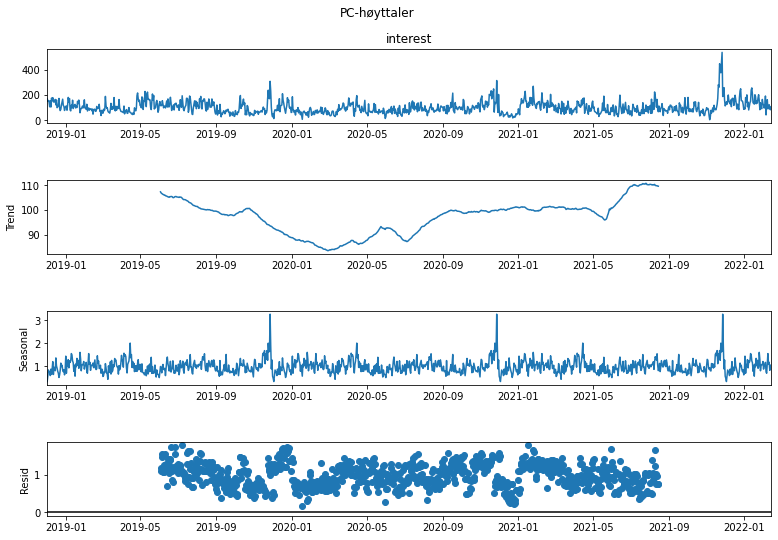

<Figure size 360x360 with 0 Axes>

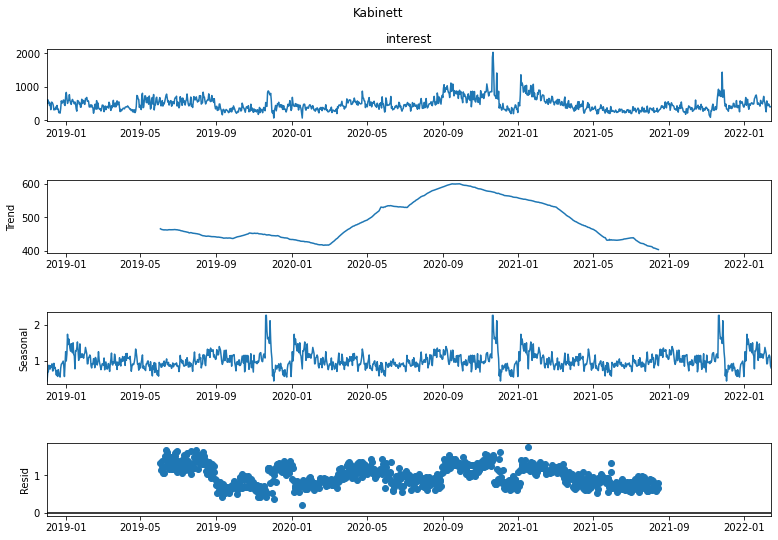

<Figure size 360x360 with 0 Axes>

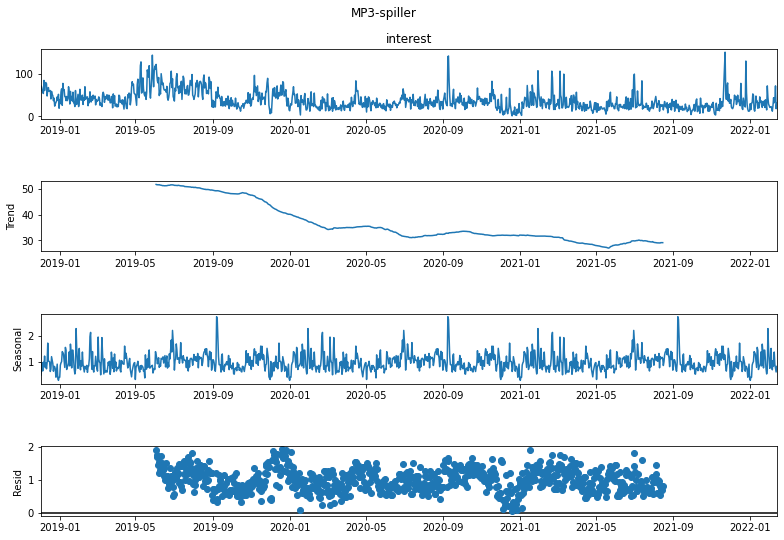

<Figure size 360x360 with 0 Axes>

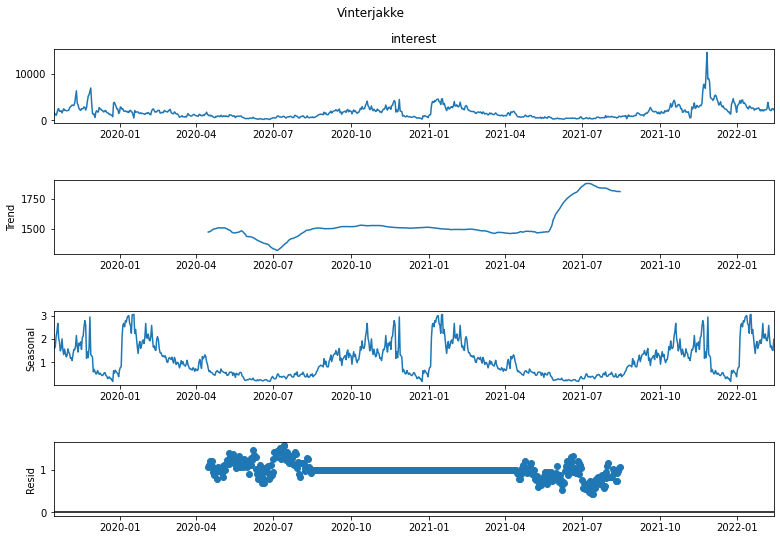

<Figure size 360x360 with 0 Axes>

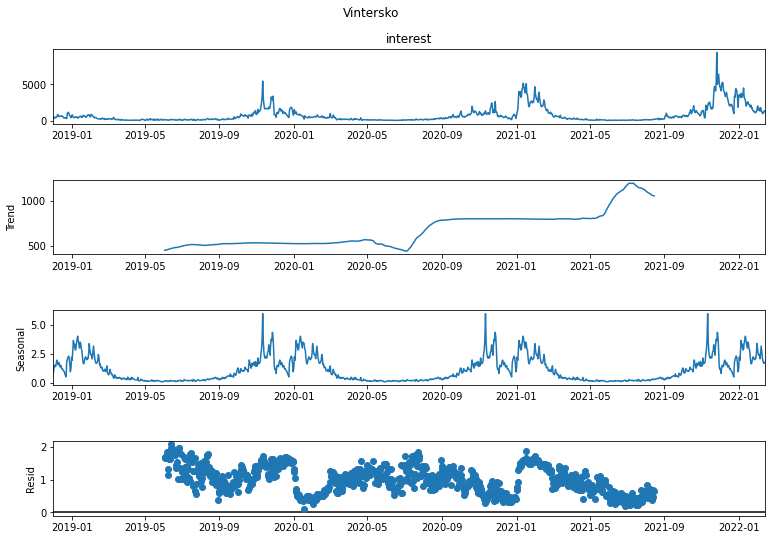

<Figure size 360x360 with 0 Axes>

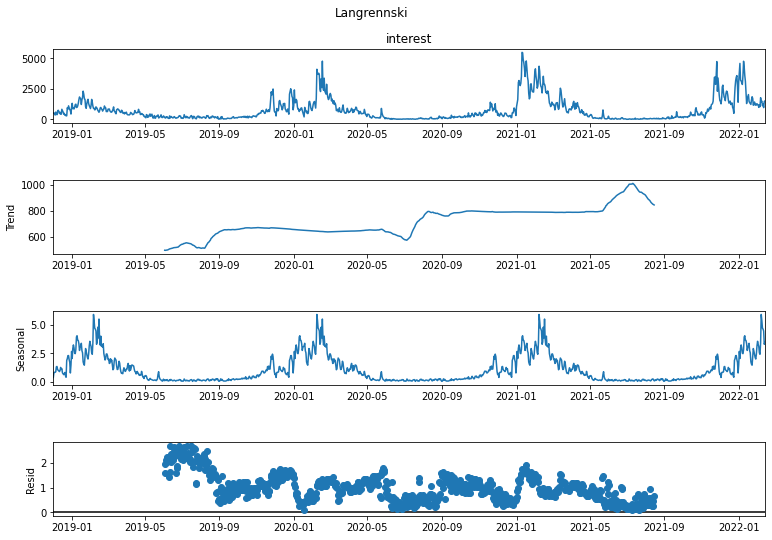

<Figure size 360x360 with 0 Axes>

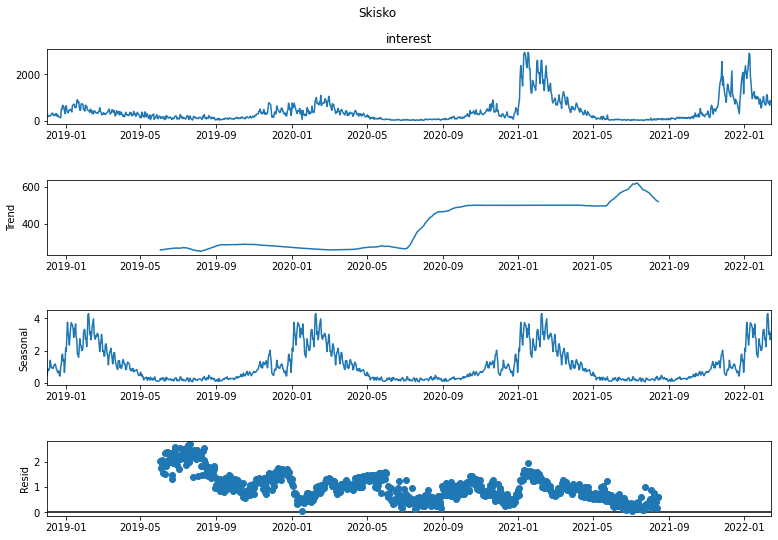

<Figure size 360x360 with 0 Axes>

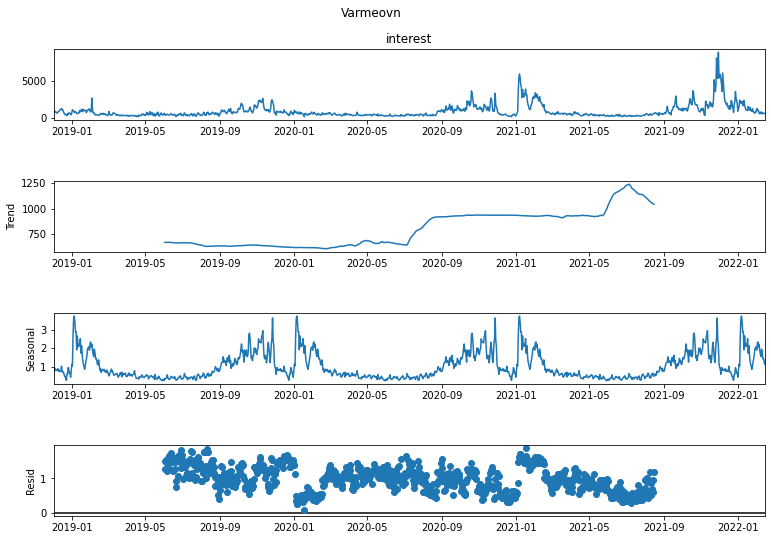

<Figure size 360x360 with 0 Axes>

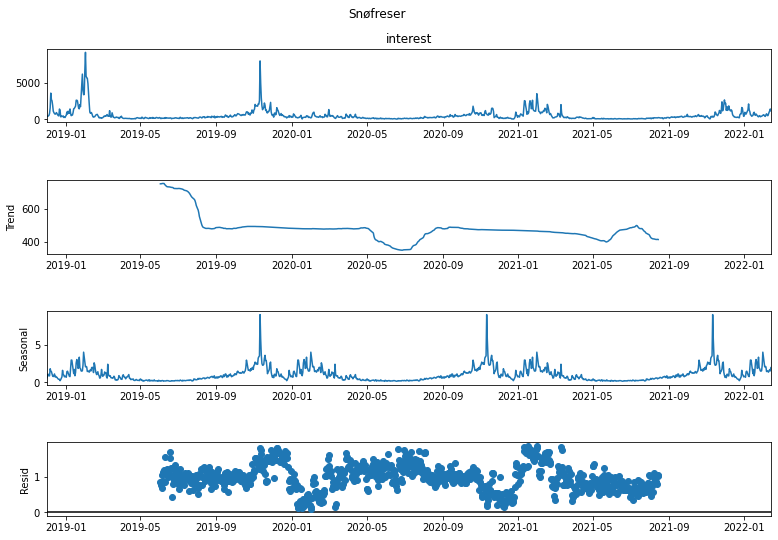

<Figure size 360x360 with 0 Axes>

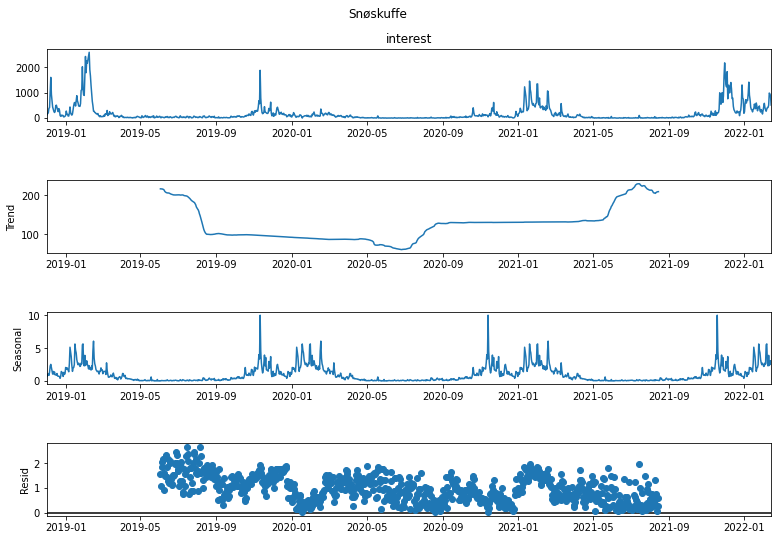

In [11]:
data_date_index = data.set_index("date", inplace=False)
df_results =  []
for cat in corr_categories + seasonal_categories :
  filtered = data_date_index[data_date_index["cat_id"] == cat]["interest"]
  cat_name = category_id_to_names_map[cat] if cat in category_id_to_names_map else cat
  decompose = seasonal_decompose(filtered, model="multiplicative", period=365)
  fig = plt.figure(figsize=(5, 5))
  fig = decompose.plot()
  fig.set_size_inches(12, 8)
  fig.suptitle(cat_name)
  fig.savefig(f"../MastersThesis/figs/code_generated/time-serie-{cat_name}_decomposed.png")

  df_result_dict = df_test(decompose.resid.dropna())
  df_results.append(df_result_dict)
df_results_dataframe = pd.DataFrame(df_results)


In [12]:
df_results_dataframe.head()
dataframe_to_latex_tabular(
    df_results_dataframe,
    caption="Dickey-Fuller test for residuals of seasonal decomposition",
    label="dickey_fuller_test_residuals",
)

/home/archie/code/Masteroppgave/notebooks/utils.py:45: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_string = df.to_latex(
